# Unit 3 Capstone

In this Capstone I will be processing a 150 question survey by over 1000 respondants to create a predictive model for the age of the respondent. The hope is that the age (and if the model user wishes, gender) can be accurately predicted given an input of responses about interests, preferences, hobbies, fears, health habits, personality traits, life views, spending habits, and general demographics. 

In [39]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble, linear_model, preprocessing, cross_validation, neighbors, tree, svm, feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.utils import resample

In [2]:
df = pd.read_csv('responses.csv')
cols = pd.read_csv('columns.csv')

In [3]:
df.head()

,Music,Slow songs or fast songs,Dance,Folk,Country,Classical music,Musical,Pop,Rock,Metal or Hardrock,...,Age,Height,Weight,Number of siblings,Gender,Left - right handed,Education,Only child,Village - town,House - block of flats
0,5.0,3.0,2.0,1.0,2.0,2.0,1.0,5.0,5.0,1.0,...,20.0,163.0,48.0,1.0,female,right handed,college/bachelor degree,no,village,block of flats
1,4.0,4.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,4.0,...,19.0,163.0,58.0,2.0,female,right handed,college/bachelor degree,no,city,block of flats
2,5.0,5.0,2.0,2.0,3.0,4.0,5.0,3.0,5.0,3.0,...,20.0,176.0,67.0,2.0,female,right handed,secondary school,no,city,block of flats
3,5.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,22.0,172.0,59.0,1.0,female,right handed,college/bachelor degree,yes,city,house/bungalow
4,5.0,3.0,4.0,3.0,2.0,4.0,3.0,5.0,3.0,1.0,...,20.0,170.0,59.0,1.0,female,right handed,secondary school,no,village,house/bungalow


In [4]:
cols.head()

,original,short
0,I enjoy listening to music.,Music
1,I prefer.,Slow songs or fast songs
2,"Dance, Disco, Funk",Dance
3,Folk music,Folk
4,Country,Country


Pop, alternative music, & reggae. Horror, romance, & science fiction. 

# Preprocessing

### Missing Data

In [5]:
df.isnull().sum().sort_values(ascending=False).head(20)

Weight                   20
Height                   20
Passive sport            15
Chemistry                10
Geography                 9
Documentary               8
Latino                    8
Smoking                   8
Punk                      8
Theatre                   8
Rock n roll               7
Countryside, outdoors     7
Gardening                 7
Techno, Trance            7
Alternative               7
Reggae, Ska               7
Classical music           7
Age                       7
Daily events              7
Compassion to animals     7
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Columns: 150 entries, Music to House - block of flats
dtypes: float64(134), int64(5), object(11)
memory usage: 1.2+ MB


In [7]:
df = df.dropna(subset = ['Smoking', 
                         'Alcohol', 
                         'Punctuality', 
                         'Lying', 
                         'Internet usage', 
                         'Gender', 
                         'Village - town', 
                         'House - block of flats'])
#I'm leaving out 'Only child', 'Education', & 'Left - right handed' for reasons explained below. 

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982 entries, 0 to 1009
Columns: 150 entries, Music to House - block of flats
dtypes: float64(134), int64(5), object(11)
memory usage: 1.1+ MB


Before we go getting our dummies now is a good time to eliminate some features that either tell us too much about age without giving anything useful or tell us nothing about age. Education, for example, is a strong indicator or the minimum age with the higher educations being reserved for only those of a certain minimum age. But it doesn't give us any insight into the respondant's personality. 

On the other hand, no pun intended, left or right handedness has no age affiliation of any kind. Yes, it would probably be filtered out by our feature selection techniques. But why not remove the noise now?

In [9]:
df = df.drop(['Only child', 'Education', 'Left - right handed', 'Number of siblings', 'Weight', 'Height'], 1)

Now I'll create dummies for the remaining categorical data

In [10]:
df = pd.get_dummies(data=df, columns=['Smoking', 
                                      'Alcohol', 
                                      'Punctuality', 
                                      'Lying', 
                                      'Internet usage', 
                                      'Gender', 
                                      'Village - town', 
                                      'House - block of flats'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982 entries, 0 to 1009
Columns: 160 entries, Music to House - block of flats_house/bungalow
dtypes: float64(131), int64(5), uint8(24)
memory usage: 1.0 MB


I don't like this drop in observations. We only have 1000 to start, spread over 16 ages. I'll try imputation.

In [12]:
from sklearn.preprocessing import Imputer

#Using most frequent to keep our values whole. We could probably also round the mean
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imp.fit(df)
df = pd.DataFrame(data=imp.transform(df) , columns=df.columns)

In [13]:
df.isnull().sum().sort_values(ascending=False).head()

House - block of flats_house/bungalow    0
House - block of flats_block of flats    0
Shopping                                 0
Celebrities                              0
Gardening                                0
dtype: int64

### Class Imbalance

(array([ 11.,  29.,  53., 116., 210., 189., 127.,  82.,  45.,  28.,  28.,
         15.,  13.,  16.,  10.,  10.]),
 array([15.    , 15.9375, 16.875 , 17.8125, 18.75  , 19.6875, 20.625 ,
        21.5625, 22.5   , 23.4375, 24.375 , 25.3125, 26.25  , 27.1875,
        28.125 , 29.0625, 30.    ]),
 <a list of 16 Patch objects>)

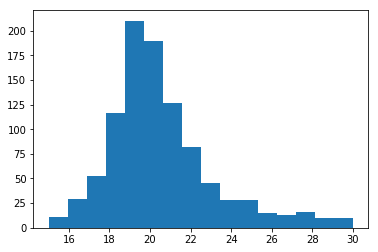

In [14]:
plt.hist(df['Age'], bins=16)

In [15]:
df['Age'].value_counts().sort_index()

15.0     11
16.0     29
17.0     53
18.0    116
19.0    210
20.0    189
21.0    127
22.0     82
23.0     45
24.0     28
25.0     28
26.0     15
27.0     13
28.0     16
29.0     10
30.0     10
Name: Age, dtype: int64

The bulk of our respondants are in the 18-22 year age group with sharp declines under 17 and over 25. In this instance it seems prudent to upsample our minority classes. 

In [16]:
df_15 = df[df.Age==15]
df_15_upsampled = resample(df_15,replace=True, n_samples=114, random_state=123)

df_16 = df[df.Age==16]
df_16_upsampled = resample(df_16,replace=True, n_samples=96, random_state=123)

df_17 = df[df.Age==17]
df_17_upsampled = resample(df_17,replace=True, n_samples=72, random_state=123)

df_22 = df[df.Age==22]
df_22_upsampled = resample(df_22,replace=True, n_samples=43, random_state=123)

df_23 = df[df.Age==23]
df_23_upsampled = resample(df_23,replace=True, n_samples=78, random_state=123)

df_24 = df[df.Age==24]
df_24_upsampled = resample(df_24,replace=True, n_samples=97, random_state=123)

df_25 = df[df.Age==25]
df_25_upsampled = resample(df_25,replace=True, n_samples=95, random_state=123)

df_26 = df[df.Age==26]
df_26_upsampled = resample(df_26,replace=True, n_samples=110, random_state=123)

df_27 = df[df.Age==27]
df_27_upsampled = resample(df_27,replace=True, n_samples=111, random_state=123)

df_28 = df[df.Age==28]
df_28_upsampled = resample(df_28,replace=True, n_samples=108, random_state=123)

df_29 = df[df.Age==29]
df_29_upsampled = resample(df_29,replace=True, n_samples=114, random_state=123)

df_30 = df[df.Age==30]
df_30_upsampled = resample(df_30,replace=True, n_samples=115, random_state=123)


# Combine majority class with upsampled minority class
df = pd.concat([df, 
                df_15_upsampled, 
                df_16_upsampled, 
                df_17_upsampled,
                df_22_upsampled,
                df_23_upsampled,
                df_24_upsampled, 
                df_25_upsampled,
                df_26_upsampled, 
                df_27_upsampled,
                df_28_upsampled, 
                df_29_upsampled,
                df_30_upsampled,
               ])

In [17]:
df['Age'].value_counts().sort_index()

15.0    125
16.0    125
17.0    125
18.0    116
19.0    210
20.0    189
21.0    127
22.0    125
23.0    123
24.0    125
25.0    123
26.0    125
27.0    124
28.0    124
29.0    124
30.0    125
Name: Age, dtype: int64

### Multicollinearity

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 0 to 774
Columns: 160 entries, Music to House - block of flats_house/bungalow
dtypes: float64(160)
memory usage: 2.6 MB


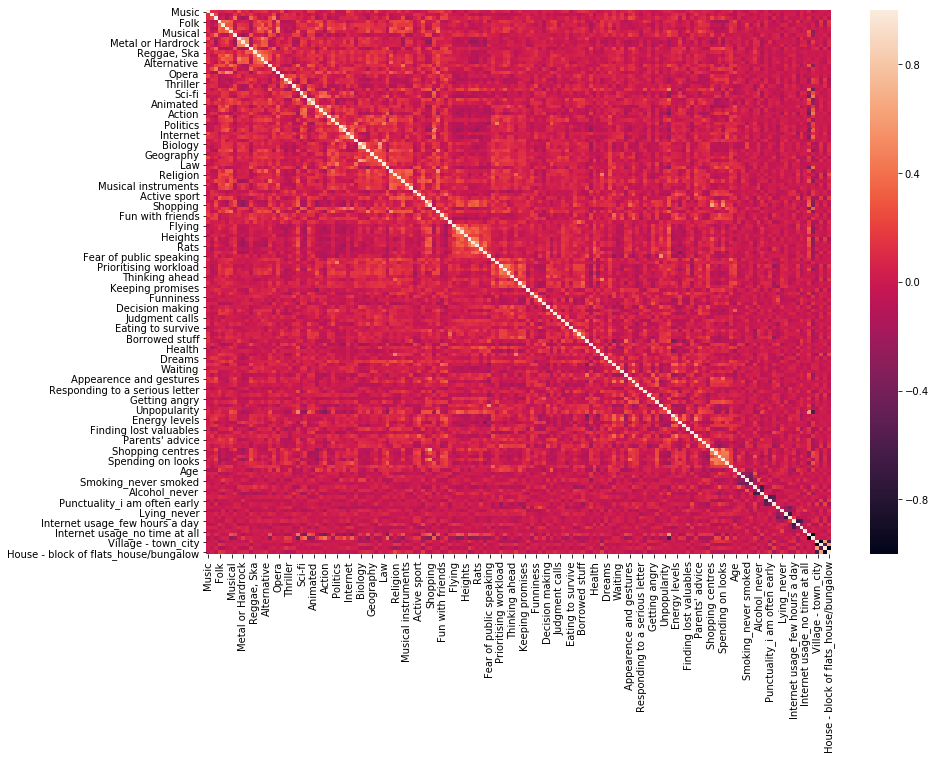

In [19]:
fig, ax = plt.subplots(figsize = (14,10)) #figsize horizontal, vertical
sns.heatmap(df.corr())

What a simple to read and totally useful heatmap! Oh wait, my mistake. It's so cluttered I can't possibly make any determinations from visual inspection of the heatmap alone. I can perform a LASSO or PCA to shrink and remove features that are correlated. But that might be counter to the purpose of this model. If I am to inform someone that 28 year-olds are often into poetry reading, and gardening but are afraid of aging and are more aware of local news I do a disservice removing some of those features because they might be correlated. It's a catch 22. 

## MODELING

## Ordinary Least Squares (X, y)

In [37]:
X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [40]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
regression_model.score(X_test, y_test)

0.6495629761092696

## Ridge Regression (X, y)

In [20]:
X = df.drop('Age', axis=1)
y = df['Age']

In [21]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [22]:
#RIDGE REGRESSIONS 
print('\nR-squared Ridge Regression, range of alpha: 1 to .00001\n')
alphas = [1, .5, .05, .001, 1e-5]

for i in alphas:
    ridgeregr = linear_model.Ridge(alpha=i, fit_intercept=False) 
    ridgeregr.fit(X_train, y_train)
    print(('R2 Score for alpha {}').format(i))
    print(ridgeregr.score(X_train, y_train))
    print('\n')


R-squared Ridge Regression, range of alpha: 1 to .00001

R2 Score for alpha 1
0.6991921762786661


R2 Score for alpha 0.5
0.6994950899755877


R2 Score for alpha 0.05
0.6996100419944022


R2 Score for alpha 0.001
0.6996113245215498


R2 Score for alpha 1e-05
0.699611325040445




## KNN Regression (X, y)

In [23]:
X = df.drop('Age', axis=1)
y = df['Age']

In [24]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [25]:
print('\nKNN Regression Score, range of neighbors: 2, 5, 10, 20')
n = [2, 5, 10, 20]

for i in n:
    neigh = KNeighborsRegressor(n_neighbors=i)
    neigh.fit(X_train, y_train)
    print(('R2 Score for n_neighbors {}').format(i))
    print(neigh.score(X_test, y_test))
    print('\n')


KNN Regression Score, range of neighbors: 2, 5, 10, 20
R2 Score for n_neighbors 2
0.7376212494610661


R2 Score for n_neighbors 5
0.5484373848446932


R2 Score for n_neighbors 10
0.32455909079777034


R2 Score for n_neighbors 20
0.1924194247460248




In [26]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
cross_val_score(neigh, X_train, y_train, cv=10)

array([0.77950604, 0.75367573, 0.72203607, 0.77289866, 0.74080193,
       0.74503382, 0.68521002, 0.66479305, 0.78751573, 0.79365281])

## KNN Regression (X_pca, y)

In [27]:
X = df.drop('Age', axis=1)
y = df['Age']
pca = PCA(n_components=40)
X_pca = pd.DataFrame(pca.fit_transform(X))

In [28]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_pca, y,test_size=0.2)

In [29]:
print('\nKNN Regression Score (X_pca), range of neighbors: 2, 5, 10, 20')
n = [2, 5, 10, 20]

for i in n:
    neigh = KNeighborsRegressor(n_neighbors=i)
    neigh.fit(X_train, y_train)
    print(('R2 Score for n_neighbors {}').format(i))
    print(neigh.score(X_test, y_test))
    print('\n')


KNN Regression Score (X_pca), range of neighbors: 2, 5, 10, 20
R2 Score for n_neighbors 2
0.887417612189052


R2 Score for n_neighbors 5
0.8156535427080008


R2 Score for n_neighbors 10
0.6995271282800257


R2 Score for n_neighbors 20
0.49382266976348704




In [30]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
cross_val_score(neigh, X_train, y_train, cv=10)

array([0.85795515, 0.87450143, 0.85160145, 0.90555476, 0.87070392,
       0.86024347, 0.87290907, 0.9059445 , 0.92349764, 0.89307894])

Noise indeed. By reducing the features to 40 from 173 the model is significantly more accurate. The range of the folds is still high. I'll run the cell above a couple more times to confirm. 

Standby...

These results have replicated reliably over six iterations. 

But what of feature importance. How can I report the importance of fearing snakes, fondness for cars, and preference of war fims to 24 year olds if my features have been altered into indecipherable PCA features? Bottom line we can't. But furthermore, even if we could, we can't do it with a KNN. For this we have to turn to...

## SVM (X, y)

In [31]:
X = df.drop('Age', axis=1)
y = df['Age']

In [32]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [33]:
svr = SVR()
svr.fit(X_train, y_train)

svr.score(X_test, y_test)

0.8596693000467094

## Gradient Boosting (X, y)

In [34]:
X = df.drop('Age', axis=1)
y = df['Age']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y,test_size=0.2)

In [35]:
clf = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, loss='huber', random_state=1)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.9026588651434341

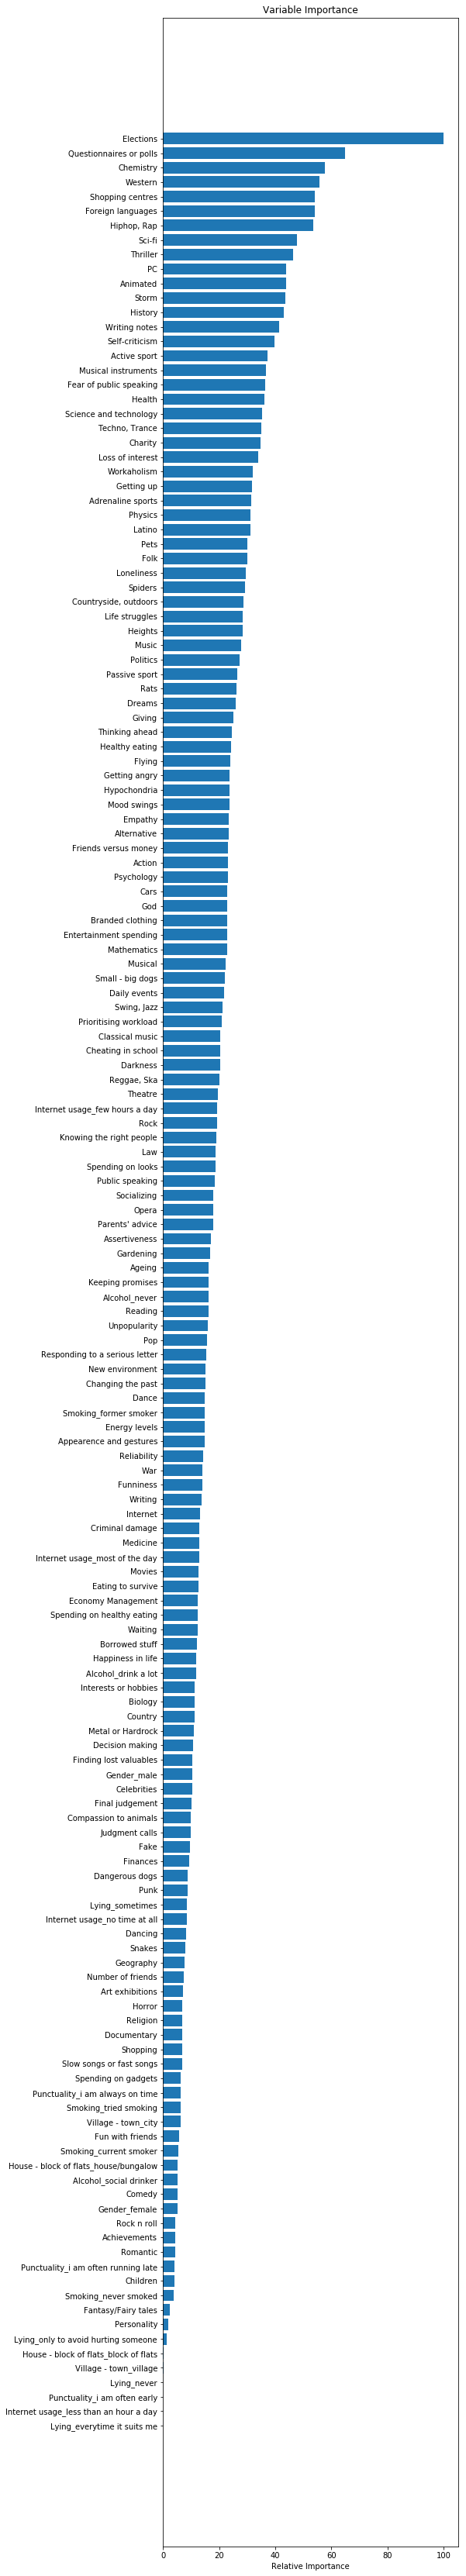

In [36]:
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,60))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [56]:
joey = [5, 3, 3, 2, 1, 2, 3, 4, 5, 1, 1, 5, 5, 3, 3, 3, 2, 1, 1, 5, 1, 4, 5, 3, 3, 3, 5, 5, 4, 1, 5, 3, 3, 2, 5, 5, 5, 3, 1, 2, 1, 5, 3, 5, 1, 1, 4, 1, 1, 5, 1, 1, 1, 5, 5, 1, 1, 3, 3, 3, 5, 3, 5, 1, 1, 1, 2, 1, 5, 1, 1, 3, 3, 1, 0, 0, 0, 0, 1, 0, 3, 3, 3, 5, 3, 3, 1, 4, 4, 4, 5, 3, 2, 1, 3, 5, 5, 5, 1, 5, 1, 3, 5, 5, 3, 5, 3, 3, 2, 3, 1, 3, 0, 0, 1, 1, 0, 0, 0, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 5, 3, 3, 4, 4, 3, 3, 3, 5, 3, 3, 3, 0, 1, 0, 0, 3, 3, 3, 3, 3, 2, 4, 1, 0, 0, 1, 1, 0]

"Joey" has values that differ from the mode for features: 'Country', 'Classical Music', 'Hiphop, Rap', 'Reggae, Ska', 'Mathematics', 'Physics', 'Cars', 'Loss of interest', 'God', 'Punctuality', 'Lying', & 'Internet Usage'. 

We can instatiate this for gender as well. But for now we'll just predict age. 

In [45]:
clf = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, loss='huber', random_state=1)

In [48]:
X = df.drop('Age', axis=1)
y = df['Age']

In [49]:
clf.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=1, subsample=1.0, verbose=0,
             warm_start=False)

In [57]:
print(clf.predict([joey]))

[23.25839206]
